## Load the tokenizer

In [1]:
import sys
sys.path.append('..')

In [2]:
from minbpe import BasicTokenizer

tokenizer = BasicTokenizer()
tokenizer.load(model_file="../output/tokenizer/my_tokenizer.model")


def get_vocab_size(tokenizer: BasicTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

## Create the model

In [3]:
import torch
torch.manual_seed(3647)

In [4]:
from transformer.model import GPTLanguageModel

block_size = 512
n_embd = 128
n_head = 8
n_layer = 1
dropout = 0.2
batch_size = 128
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

0.529418 M parameters


## Data preparation

### 1. Load the data

In [5]:
with open("../output/combined_text.txt", "r") as f:
    text_sequence = f.read()

encoded_text_sequence = tokenizer.encode(text_sequence)
len(encoded_text_sequence)

912

### 2. Split it into train and test

In [6]:
data = torch.tensor(encoded_text_sequence, dtype=torch.long)
split_index = int(0.9*len(data))
train_data = data[:split_index]
val_data = data[split_index:]

### 3. Data loader

In [7]:
from typing import Tuple


def get_batch(split: str) -> Tuple[torch.Tensor, torch.Tensor]:
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    index = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in index])
    y = torch.stack([data[i+1:i+block_size+1] for i in index])
    x, y = x.to(device), y.to(device)
    return x, y


## 📄 Function: `get_batch(split: str)`

This function creates a small batch of input and target sequences for training or validation. It returns two tensors: `x` (inputs) and `y` (targets), both ready to be fed into a model.

### 🔧 Code Breakdown

```python
from typing import Tuple
```

* This line allows us to specify that the function will return a **tuple** of two PyTorch tensors.

```python
def get_batch(split: str) -> Tuple[torch.Tensor, torch.Tensor]:
```

* Defines the function `get_batch` that takes a string `split`, which should be either `'train'` or `'val'`.
* It returns two PyTorch tensors: the input batch `x` and the target batch `y`.

```python
    data = train_data if split == 'train' else val_data
```

* Depending on the `split`, it selects the training or validation data.

```python
    index = torch.randint(len(data) - block_size, (batch_size,))
```

* Randomly selects `batch_size` starting positions from the data to generate sequences.
* `block_size` is the length of each input sequence.

```python
    x = torch.stack([data[i:i+block_size] for i in index])
```

* For each index, extract a sequence of length `block_size` from the data.
* These sequences are stacked into a batch `x`.

```python
    y = torch.stack([data[i+1:i+block_size+1] for i in index])
```

* Creates the target batch `y`, which is the same as `x` but shifted one position forward. This is typically used in language models to predict the next token.

```python
    x, y = x.to(device), y.to(device)
```

* Moves the tensors to the desired computing device (CPU or GPU).

```python
    return x, y
```

* Returns the input and target batches.

---

### 🧠 Summary

* The function creates batches of sequences for model training or evaluation.
* Each input `x` is a chunk of tokens, and the corresponding `y` is the same chunk shifted one token ahead.
* It's commonly used for training autoregressive models like GPT.



In [8]:
x, y = get_batch('train')
x.shape, y.shape

(torch.Size([128, 512]), torch.Size([128, 512]))


## 🧪 Using the `get_batch` Function

```python
x, y = get_batch('train')
x.shape, y.shape
```

### 🔍 What This Does:

* Calls the `get_batch` function with `'train'` to get a **training batch**.
* `x` is the **input tensor**.
* `y` is the **target tensor**, which is the input shifted one position ahead.
* `.shape` returns the shape (dimensions) of the tensors.

### 📐 Expected Output Shape:

Assuming the following variables are defined:

```python
batch_size = 32        # number of sequences in one batch
block_size = 128       # length of each sequence
```

Then:

```python
x.shape == (32, 128)
y.shape == (32, 128)
```

Each batch contains:

* `32` sequences
* Each of length `128` tokens


### 4. Training

In [9]:
from typing import Dict

eval_iters = 200


@torch.no_grad()
def estimate_loss() -> Dict:
    output = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_batch(split)
            _, loss = model(x, y)
            losses[k] = loss.item()
        output[split] = losses.mean()
    model.train()
    return output



## 📄 Function: `estimate_loss()`

This function estimates the **average loss** of the model on both the **training** and **validation** datasets. It's typically used to monitor how well the model is learning.

---

### 🔧 Code Explanation

```python
from typing import Dict
```

* This allows the function to specify that it returns a dictionary (i.e. `Dict`).

```python
eval_iters = 200
```

* The number of iterations (batches) used to estimate the average loss for each split (`train` and `val`).

```python
@torch.no_grad()
```

* A decorator that tells PyTorch **not to compute gradients**. This saves memory and speeds up the evaluation process, since we're not training here—just measuring performance.

```python
def estimate_loss() -> Dict:
```

* Defines the function `estimate_loss`, which returns a dictionary with average losses for `'train'` and `'val'`.

```python
    output = {}
```

* An empty dictionary to store the average losses.

```python
    model.eval()
```

* Sets the model to **evaluation mode**, which turns off dropout and other training-specific behaviors.

```python
    for split in ['train', 'val']:
```

* Loops over the two data splits: `'train'` and `'val'`.

```python
        losses = torch.zeros(eval_iters)
```

* Creates a tensor to store the loss values for each of the `eval_iters` iterations.

```python
        for k in range(eval_iters):
            x, y = get_batch(split)
            _, loss = model(x, y)
            losses[k] = loss.item()
```

* For each iteration:

  * Gets a batch of input (`x`) and target (`y`) data.
  * Feeds them into the model.
  * Extracts the loss and stores it in the `losses` tensor.

```python
        output[split] = losses.mean()
```

* Calculates the average loss for the split and stores it in the `output` dictionary.

```python
    model.train()
```

* Puts the model back into **training mode**, so it's ready to continue training after the evaluation.

```python
    return output
```

* Returns the dictionary with average training and validation losses.

---

### 📌 Example Output

After calling `estimate_loss()`, you might get something like:

```python
{'train': 1.923, 'val': 2.140}
```

This means:

* The model's average training loss is `1.923`.
* The model's average validation loss is `2.140`.

---

### 🧠 What It Does

- Disables gradient tracking with `@torch.no_grad()` for efficient evaluation.
- Loops through `eval_iters` times to compute average loss on both `train` and `val` datasets.
- Switches the model to **evaluation mode** during loss estimation and back to **training mode** afterward.
- Returns a dictionary like: `{'train': 1.923, 'val': 2.140}`

### 📈 Purpose

Useful for monitoring how well the model is learning, without affecting its gradients or training process.



In [10]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)


## 💾 Function: `save_checkpoint(...)`

This function **saves the model's state** and other important training info (like the optimizer and loss) into a file. It's used to **resume training later** or **keep a backup** of a trained model.

---

### 🔧 Code Explanation

```python
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
```

* Defines the `save_checkpoint` function.
* **Parameters:**

  * `model`: The GPT model to save.
  * `optimizer`: The optimizer used during training (e.g. Adam).
  * `epoch`: The current epoch number (for resuming training).
  * `loss`: The latest loss value (for reference).
  * `file_path`: The file name to save the checkpoint (default: `checkpoint.pth`).

```python
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
```

* Creates a dictionary called `checkpoint` containing:

  * The current epoch number
  * The model's state (weights and parameters)
  * The optimizer's state (learning rates, momentum, etc.)
  * The current loss value

```python
    torch.save(checkpoint, file_path)
```

* Uses PyTorch’s `torch.save` function to write the `checkpoint` to disk.

---

### 📦 What This Is Used For

Saving a checkpoint allows you to:

* Resume training from where you left off.
* Avoid losing progress due to crashes or interruptions.
* Load the model later for evaluation or inference.

---


In [11]:
max_iters = 1000
eval_interval = 10
learning_rate = 1e-4
save_interval = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for iteration in range(max_iters):
    if iteration % eval_interval == 0 or iteration == max_iters - 1:
        losses = estimate_loss()
        print(
            f"step {iteration}: "
            f"train loss {losses['train']:.4f}, "
            f"val loss {losses['val']:.4f}"
        )
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

    x_batch, y_batch = get_batch('train')
    logits, loss = model(x_batch, y_batch)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if iteration % save_interval == 0:
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            epoch=iteration,
            loss=loss.item(),
            file_path=f"../output/pre_training/run_1/checkpoint_{iteration}.pth"
        )

InductorError: RuntimeError: Compiler: cl is not found.

Set TORCHDYNAMO_VERBOSE=1 for the internal stack trace (please do this especially if you're reporting a bug to PyTorch). For even more developer context, set TORCH_LOGS="+dynamo"


## 🚀 Training Loop (Line-by-Line Explanation)

This code trains a language model using the AdamW optimizer. It evaluates the loss at regular intervals, saves the model periodically, and collects training/validation losses for monitoring.

---

### 🧠 Setup

```python
max_iters = 1000                # Total number of training iterations (batches)
eval_interval = 10              # How often (in iterations) to evaluate and print loss
learning_rate = 1e-4            # Learning rate for the optimizer
save_interval = 100             # How often (in iterations) to save the model
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)  # Initialize the optimizer
```

- We train the model for 1000 steps.
- Every 10 steps, we evaluate how well the model is doing.
- Every 100 steps, we save the model checkpoint.
- We use the `AdamW` optimizer, which is good for training transformers.

```python
train_losses = []   # List to store training loss over time
val_losses = []     # List to store validation loss over time
```

---

### 🔁 Training Loop

```python
for iteration in range(max_iters):   # Loop over training steps
```

- Loop from `0` to `999` (total 1000 iterations).

```python
    if iteration % eval_interval == 0 or iteration == max_iters - 1:
```

- Every `eval_interval` steps (e.g. every 10 steps), or on the final step:
- We check how the model is performing.

```python
        losses = estimate_loss()  # Estimate the average train and val loss
```

- Calls the `estimate_loss()` function to evaluate how well the model is doing on both training and validation data.

```python
        print(
            f"step {iteration}: "
            f"train loss {losses['train']:.4f}, "
            f"val loss {losses['val']:.4f}"
        )
```

- Prints the current step and the train/validation loss (rounded to 4 decimal places).

```python
        train_losses.append(losses['train'])  # Save the train loss to list
        val_losses.append(losses['val'])      # Save the val loss to list
```

- Appends the losses to their respective lists so you can track them later (e.g. plot a graph).

---

### 🧪 Model Training Step

```python
    x_batch, y_batch = get_batch('train')  # Get a batch of training data
```

- Retrieves a random batch of input/output pairs for training.

```python
    logits, loss = model(x_batch, y_batch)  # Forward pass: predict and calculate loss
```

- Feeds the input batch through the model.
- Gets predictions (`logits`) and calculates the loss.

```python
    optimizer.zero_grad(set_to_none=True)  # Clear previous gradients
```

- Clears old gradients before computing new ones.

```python
    loss.backward()  # Backward pass: compute gradients
```

- Calculates gradients by backpropagation.

```python
    optimizer.step()  # Update model weights
```

- Applies the gradients to update the model parameters.

---

### 💾 Save Checkpoint

```python
    if iteration % save_interval == 0:
```

- Every `save_interval` steps (e.g. every 100 steps):

```python
        save_checkpoint(
            model=model,
            optimizer=optimizer,
            epoch=iteration,
            loss=loss.item(),
            file_path=f"../output/pre_training/run_1/checkpoint_{iteration}.pth"
        )
```

- Saves the model, optimizer state, current step (`iteration`), and current loss to a checkpoint file.
- File is named like `checkpoint_0.pth`, `checkpoint_100.pth`, etc.

---

### ✅ Summary

This training loop does the following:
- Trains a language model for 1000 iterations.
- Evaluates and prints loss every 10 steps.
- Saves the model every 100 steps.
- Tracks loss history for plotting or analysis.


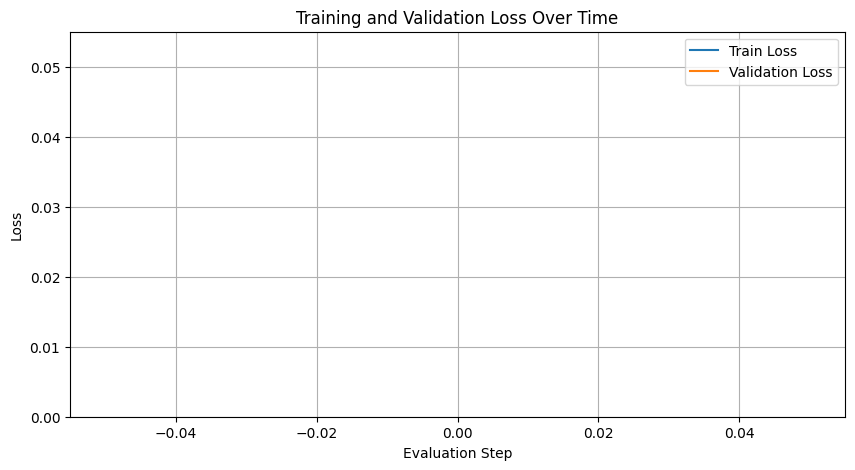

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylim(0)
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

## 📊 Plotting Training and Validation Loss

This code visualizes how the training and validation losses change over time during model training.

```python
import matplotlib.pyplot as plt  # Import the plotting library
```

```python
plt.figure(figsize=(10, 5))     # Create a figure of size 10x5 inches
```

```python
plt.plot(train_losses, label="Train Loss")        # Plot training loss curve
plt.plot(val_losses, label="Validation Loss")     # Plot validation loss curve
```

```python
plt.xlabel("Evaluation Step")      # Label for the x-axis
plt.ylim(0)                       # Set the y-axis to start from 0 (no negative loss)
plt.ylabel("Loss")                # Label for the y-axis
plt.title("Training and Validation Loss Over Time")  # Chart title
plt.legend()                     # Show legend to distinguish train/val curves
plt.grid()                       # Add grid lines for better readability
plt.show()                       # Display the plot
```

### What You’ll See

- A line graph with two curves:
  - **Train Loss** decreasing as the model learns.
  - **Validation Loss** showing how well the model performs on unseen data.
- The x-axis shows evaluation steps (every time loss was calculated).
- The y-axis shows the loss values.

This helps you visually check if the model is improving and if it’s overfitting or underfitting.



In [ ]:
input_tokens = tokenizer.encode("Salam labas")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=50)

print(tokenizer.decode(output[0].tolist()))

## 📝 Generating Text with the Model

This code takes an input text, processes it, and uses the model to generate new text based on that input.

```python
input_tokens = tokenizer.encode("Salam labas")
```
- Converts the input text `"Salam labas"` into a list of token IDs using the tokenizer.

```python
input_tokens = torch.tensor(input_tokens, dtype=torch.long).unsqueeze(0).to(device)
```
- Converts the list of tokens into a PyTorch tensor.
- `.unsqueeze(0)` adds a batch dimension, making it shape `(1, sequence_length)`.
- Moves the tensor to the device (CPU or GPU) where the model is located.

```python
model.eval()
```
- Sets the model to evaluation mode (disables dropout and other training behaviors).

```python
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=50)
```
- Disables gradient computation (since we’re only generating text, not training).
- Uses the model’s `.generate()` method to produce up to 50 new tokens based on the input.

```python
print(tokenizer.decode(output[0].tolist()))
```
- Converts the generated token IDs back to text.
- Prints the generated text output.

---

### Summary

This snippet generates text starting from `"Salam labas"` and continues for 50 tokens, showing the model’s prediction in natural language.

